In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import re
from scipy.optimize import fmin

def read_csv_as_dict(file_path):
    """
    Read a csv file and return a dictionary with the data
    """

    data_dict = {}

    with open(file_path, 'r') as csv_file:
        # skip first line if it starts with '#'
        if csv_file.readline().startswith('#'):
            next(csv_file)

        for line in csv_file:
            # Use regular expression to split line based on consecutive whitespace
            row = re.split(r'\s+', line.strip())
            
            key = row[-1]  # Last element of the row as the key
            values = np.array([float(val) if val.replace('.', '', 1).isdigit() or (val[0] == '-' and val[1:].replace('.', '', 1).isdigit()) else val for val in row[:-1]], dtype=object)
            data_dict[key] = values

    return data_dict

def list_files_in_folder(directory, start_pattern):
    """
    List all files in a folder that start with a specified pattern
    """

    file_list = []

    # Iterate over all files in the folder
    for filename in os.listdir(directory):
        # Check if the filename starts with the specified pattern
        if filename.startswith(start_pattern):
            file_list.append(filename)

    #order the list by number
    file_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    return file_list

def read_data_by_planet(planet_name, list, property, directory):
    """
    Read data from a list of files for a specified planet and property
    """

    data = np.zeros((len(list), 3))

    if property == 'position':
        indexes = [0, 1, 2]
    elif property == 'velocity':
        indexes = [3, 4, 5]
    elif property == 'force':
        indexes = [6, 7, 8]
    else:
        raise ValueError('Invalid property')

    for i, file in enumerate(list):
        result = read_csv_as_dict(directory + file)
        data[i] = result[planet_name][indexes]

    return data    

def computeError(positions, positions_ref):
    error = sum(np.linalg.norm(positions - positions_ref, axis=1)**2)**0.5
    return error

for planet in ['mercury', 'venus', 'earth', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune']:
    list_true = list_files_in_folder('trajectories/', 'step')
    list_simulation = list_files_in_folder('../build/dumps/', 'step')
    position_true = read_data_by_planet(planet, list_true, 'position', 'trajectories/')
    position_simulation = read_data_by_planet(planet, list_simulation, 'position', '../build/dumps/')
    velocity_true = read_data_by_planet(planet, list_true, 'velocity', 'trajectories/')
    velocity_simulation = read_data_by_planet(planet, list_simulation, 'velocity', '../build/dumps/')
    error_position = computeError(position_simulation, position_true)
    error_velocity = computeError(velocity_simulation, velocity_true)
    print('Error for planet ' + planet + ' : pos_error = ' + str(error_position) + ' vel_error = ' + str(error_velocity))


Error for planet mercury : pos_error = 0.5165091868605669 vel_error = 0.01802202482313605
Error for planet venus : pos_error = 0.7867926766725032 vel_error = 0.013048139261165284
Error for planet earth : pos_error = 0.633982336451083 vel_error = 0.006485490834355664
Error for planet mars : pos_error = 0.624308252452014 vel_error = 0.003253459288143698
Error for planet jupiter : pos_error = 0.1420112126210599 vel_error = 0.00011367299588731453
Error for planet saturn : pos_error = 0.10792388432847781 vel_error = 3.270424673494259e-05
Error for planet uranus : pos_error = 0.07350092538489982 vel_error = 7.632756754170908e-06
Error for planet neptune : pos_error = 0.059937302811958096 vel_error = 3.1424168702989956e-06


We notice Mercury has indeed the highest error.

In what follows there are routines to run the simulations with scaled initial velocity

In [2]:
def generate_input(scale, planet_name, input_filename, output_filename):
    # Read data from the input file using read_csv_as_dict
    data_dict = read_csv_as_dict(input_filename)

    # Process the velocity scaling for the specified planet
    if planet_name in data_dict:
        velocity_indexes = [3, 4, 5]  # Assuming VX, VY, VZ are at indices 3, 4, 5 in the row
        data_dict[planet_name][velocity_indexes] *= scale

    # Write the modified data to the output file
    with open(output_filename, 'w') as outfile:
        # Write the header lines (sun is not scaled)
        outfile.write("#X Y Z VX VY VZ FX FY FZ mass radius name\n")
        outfile.write("0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 333060.401628 sun \n")
        # Write the data lines
        count = 0
        planet_name = list(data_dict.keys())
        for values in data_dict.values():
            outfile.write(' '.join(map(str, values)) + ' ' + planet_name[count] + ' \n')
            count += 1

def launchParticles(input,nb_steps,freq):
    """
    Launches the simulation with the specified input file for the specified number of steps and with the specified output frequency
    """

    # Launch the simulation
    os.system('python3 main.py ' + str(nb_steps) + ' ' + str(freq) + ' ' + input + ' planet 1')

def runAndComputeError(scale,planet_name,input,nb_steps,freq):
    """
    Runs the simulation with scaled velocity and computes the error
    """
    generate_input(scale, planet_name, input, 'init_scaled.csv')
    os.chdir('../build')
    launchParticles('../src/init_scaled.csv', nb_steps, freq)
    os.chdir('../src')
    list_true = list_files_in_folder('trajectories/', 'step')
    list_simulation = list_files_in_folder('../build/dumps/', 'step')
    position_true = read_data_by_planet(planet_name, list_true, 'position', 'trajectories/')
    position_simulation = read_data_by_planet(planet_name, list_simulation, 'position', '../build/dumps/')
    error_position = computeError(position_simulation, position_true)
    return error_position

Optimization study to find the minimum error on the trajectory of mercury

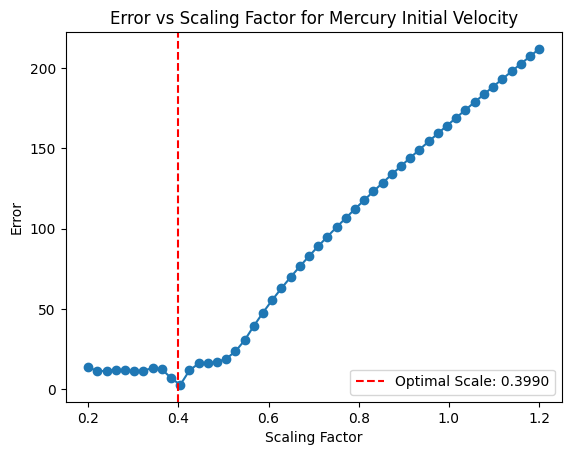

Optimal Scaling Factor: 0.3990


In [3]:
scaling_factors = np.linspace(0.2, 1.2, 50) 
errors = []

for scale in scaling_factors:
    error = runAndComputeError(scale,'mercury','init.csv',365,1)
    errors.append(error)

# Find the optimal scaling factor that minimizes the error
optimal_scale = fmin(runAndComputeError, 1.0, args=('mercury', 'init.csv', 365, 1), disp=False)

# Plot the evolution of the error versus the scaling factor
plt.plot(scaling_factors, errors, marker='o')
plt.xlabel('Scaling Factor')
plt.ylabel('Error')
plt.title('Error vs Scaling Factor for Mercury Initial Velocity')
plt.axvline(x=optimal_scale, color='r', linestyle='--', label=f'Optimal Scale: {optimal_scale[0]:.4f}')
plt.legend()
plt.show()

print(f'Optimal Scaling Factor: {optimal_scale[0]:.4f}')

In [4]:
minimum_error = runAndComputeError(optimal_scale[0],'mercury','init.csv',365,1)
print(f'Minimum Error: {minimum_error:.4f}')

Minimum Error: 0.5165
